# Pokemon GAN Training Notebook

## **Import libraries**

In [1]:
import sys
sys.path.append('../sources')

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from ACGAN import AuxGAN
import utils as ut
import os
import variable as var
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [3]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 7.39 GB
used     : 396.31 MB	(5.24%)


## **Load DATASET**

In [4]:
train_number = 'example_2'
gan_id = f"acgan_cp_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 64
label_name = 'type_12'
normalize_input = 'min_max_scale'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [7]:
dset = PokemonGensDataset(label_name=label_name, greyscale=greyscale, normalize=normalize_input,
                          resize=[resize_image_dim, resize_image_dim], 
                          gens_to_remove=("gen8", "gen7", "gen6", "gen1"))
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'dataset: {len(dset)} images')

dataset: 3941 images


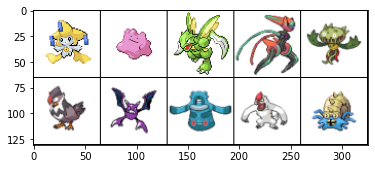

array([['steel', 'normal-fighting', 'grass-bug', 'psychic-ghost-dark',
        'grass-bug'],
       ['flying', 'poison', 'steel', 'normal-fighting', 'ground-rock']],
      dtype='<U18')

In [11]:
images, labels = next(iter(dloader))
ut.show_images_grid(images)
np.array([dset.label_id_to_label_name[i] for i in labels[:10].tolist()]).reshape(2, 5)

apply weights on inputs based on element wise auxiliary own class probability prediction
to do: in the generator loss function, multiply each sample-loss-value (torch.NLLLoss) value by its own class probability given by the discriminator. 


## **GAN Component**

In [14]:
gen_lr = 1e-4 # 9e-5
disc_lr = 1e-4 # 9e-5
beta1 = .9 # .9
beta2 = .999
betas = {'1': beta1, '2': beta2}
n_channel = 1 if greyscale else 3
n_feature = 32 # 25
z_dim = 60 # 60
n_classes = len(dset.label_id_to_label_name)
use_inception = True
embedding = True
label_smoothing = True
generator_type = 'color_picker'

    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': betas,
                  'embedding': embedding},
          'disc': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': disc_lr,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes,
          'dataset': dset.describe(),
          'batch_size': batch_size,
          'label_smoothing': label_smoothing,
          'use_inception': use_inception,
          'generator_type': generator_type
         }

## **GAN INIT AND TRAINING**

In [15]:
gan = AuxGAN(params)
checkpoint_path = os.path.join(var.PROJECT_DIR, f'data/models/{gan_id}.pth')
if os.path.exists(checkpoint_path):
    print('RESUMING TRAINING...')
    gan.load_model(checkpoint_path)
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: acgan_cp_pokemon_train_example_2


In [16]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [31]:
gan.train(n_epoch=150, dataloader=dloader, gan_id=gan_id) #PB IS EMBEDDING

100%|██████████| 150/150 [28:35<00:00, 11.44s/it]


## **RESULT VIZUALIZATION**

**Auxiliary based class Generation**

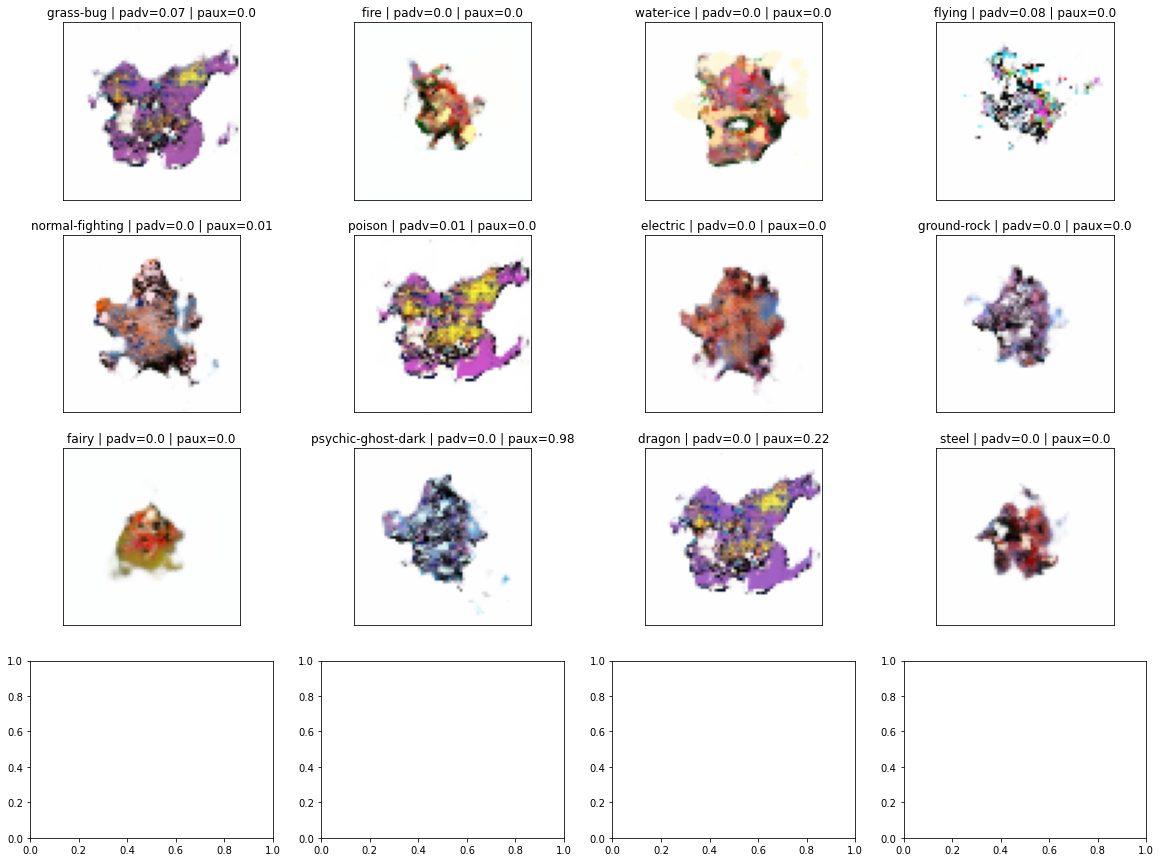

In [41]:
being_class = 9
n = 1
noise = - torch.ones(n, z_dim, 1, 1, device=var.device) 
noise = gan.get_random_noise(n)
n_label = len(dset.label_id_to_label_name)
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, (label_id, label_name) in enumerate(dset.label_id_to_label_name.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        adv, aux = gan.discriminator(fakes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    with warnings.catch_warnings():
        fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
        axes[i][j].imshow(fakes_grid)
    axes[i][j].set_title(f"{dset.label_id_to_label_name[label_id]} | padv={round(adv.squeeze().item(), 2)} | paux={round(aux.squeeze()[label_id].item(), 2)}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)

class: grass-bug


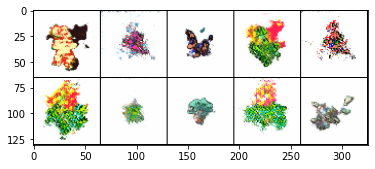

fake/real precision: 1.0
auxiliary precision: 0.6
--------------------------------------------------------------------------
class: fire


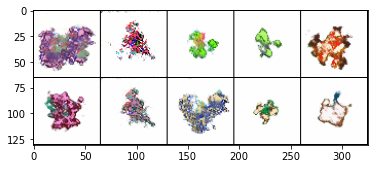

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: water-ice


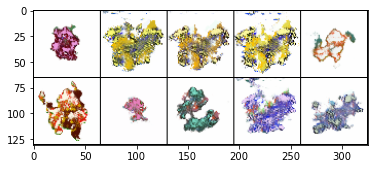

fake/real precision: 1.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: flying


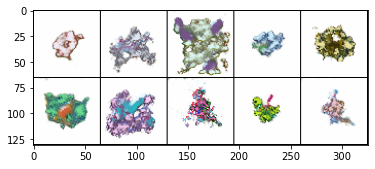

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: normal-fighting


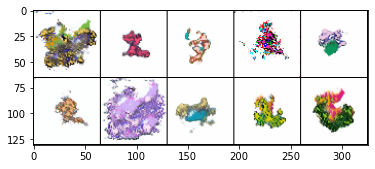

fake/real precision: 1.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: poison


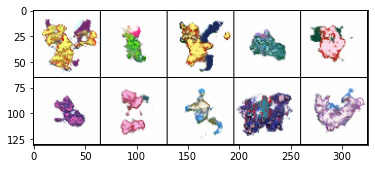

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: electric


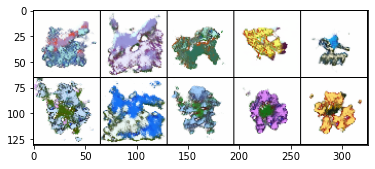

fake/real precision: 1.0
auxiliary precision: 0.1
--------------------------------------------------------------------------
class: ground-rock


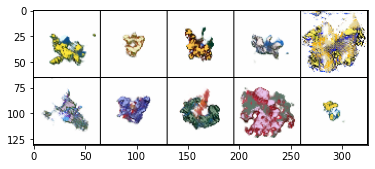

fake/real precision: 0.9
auxiliary precision: 0.5
--------------------------------------------------------------------------
class: fairy


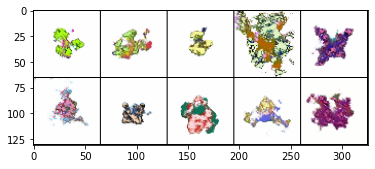

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: psychic-ghost-dark


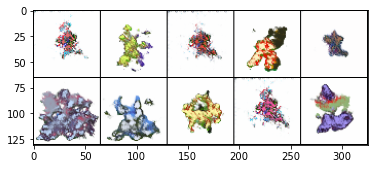

fake/real precision: 1.0
auxiliary precision: 0.5
--------------------------------------------------------------------------
class: dragon


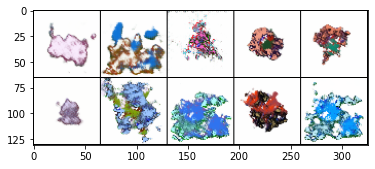

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------
class: steel


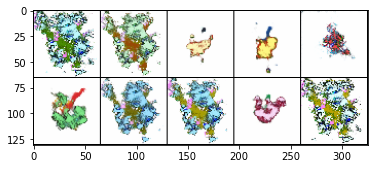

fake/real precision: 1.0
auxiliary precision: 0.0
--------------------------------------------------------------------------


In [21]:
for label_id, label_name in dset.label_id_to_label_name.items():
    print(f"class: {dset.label_id_to_label_name[label_id]}")
    with torch.no_grad():
        fakes, classes = gan.generate_fake(10, train=False, being_class=label_id)
        adv, aux = gan.discriminator(fakes)
        adv_label = adv < .5
        aux_label = torch.argmax(aux, dim=1) == classes.cuda()

    ut.show_images_grid(fakes)
    print(f"fake/real precision: {round((adv_label.sum()/ len(adv_label)).item(), 3)}")
    print(f"auxiliary precision: {round((aux_label.sum()/ len(aux_label)).item(), 3)}")
    print("--------------------------------------------------------------------------")

In [28]:
if False:
    ut.delete_gans_id(gan_id)

________________________________________

tensor([[0.6200]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.8667, 0.1333]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([0], device='cuda:0')


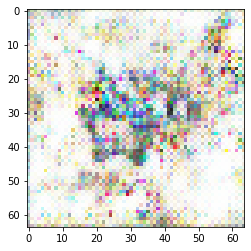

In [31]:
fake_0, class_0 = gan.generate_fake(1, train=False, being_class=0)
adv_0, aux_0 = gan.discriminator(fake_0)
print(adv_0)
print(aux_0)
print(torch.argmax(aux_0, dim=1))
ut.show_images_grid(fake_0)

tensor([[0.6181]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.1165, 0.8835]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1], device='cuda:0')


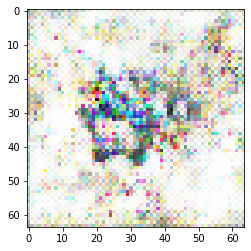

In [32]:
fake_1, class_1 = gan.generate_fake(1, train=False, being_class=1)
adv_1, aux_1 = gan.discriminator(fake_1)
print(adv_1)
print(aux_1)
print(torch.argmax(aux_1, dim=1))
ut.show_images_grid(fake_1)

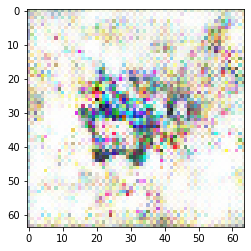

In [38]:
n = 1
noise = torch.ones(n, z_dim, 1, 1, device=var.device) 
classes = torch.ones((n, ), device=var.device).long() * 1
fakes = gan.generator.forward(noise, classes)
ut.show_images_grid(fakes)

TypeError: 'AxesSubplot' object is not subscriptable

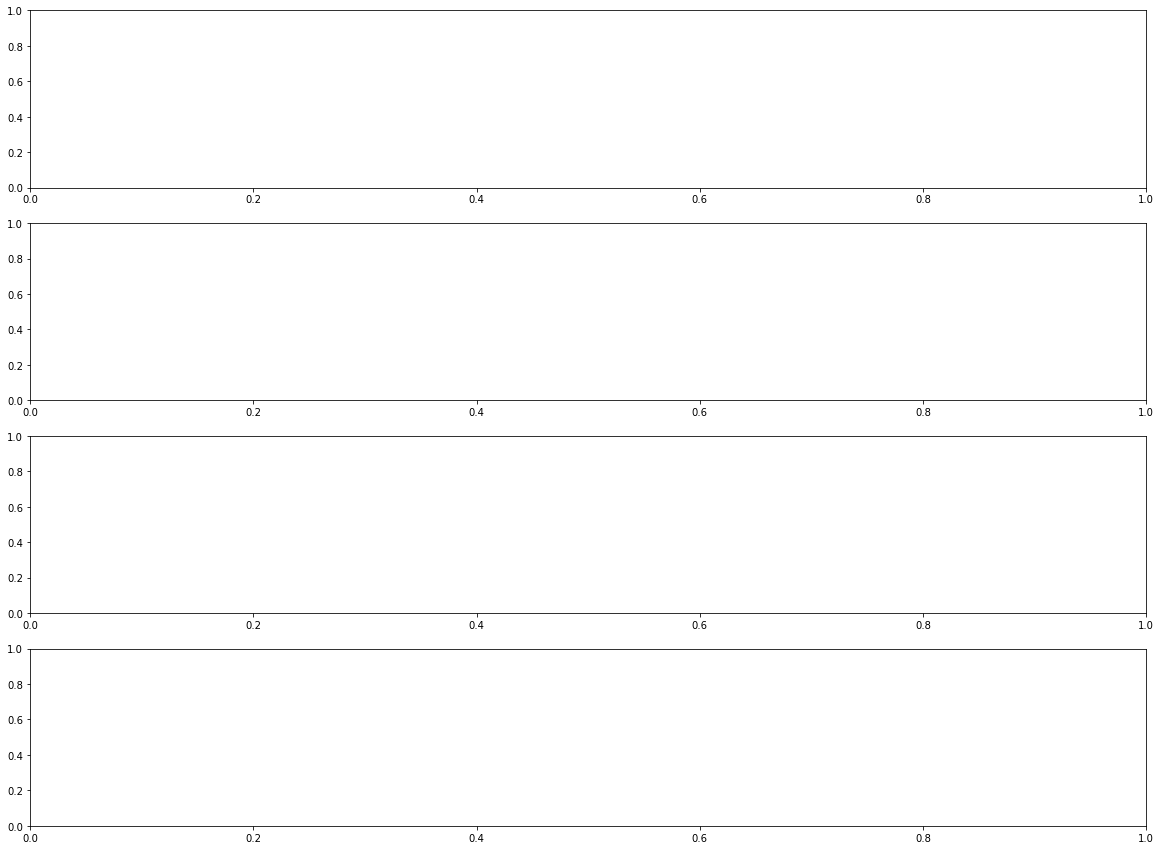

In [33]:
being_class = 9
n = 2
noise = torch.ones(n, z_dim, 1, 1, device=var.device) 
noise = gan.get_random_noise(n)
n_label = len(dset.label_id_to_label_name)
n_label_per_row = 4
n_label_per_col = (n_label // n_label_per_row) + 1
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_label_per_row, 
                                 ncols=n_label_per_col)
for idx, (label_id, label_name) in enumerate(dset.label_id_to_label_name.items()):
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * label_id
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
        
    i = idx // n_label_per_col
    j = idx % n_label_per_col
    fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
    adv, aux = gan.discriminator(fakes)
    axes[i][j].imshow(fakes_grid)
    axes[i][j].set_title(f"{dset.label_id_to_label_name[label_id]} | adv: {round(adv[0].item(), 2)} | aux: {round(aux[0][label_id].item(), 2)}")
    axes[i][j].xaxis.set_visible(False)
    axes[i][j].yaxis.set_visible(False)
    

**Noise based viz**

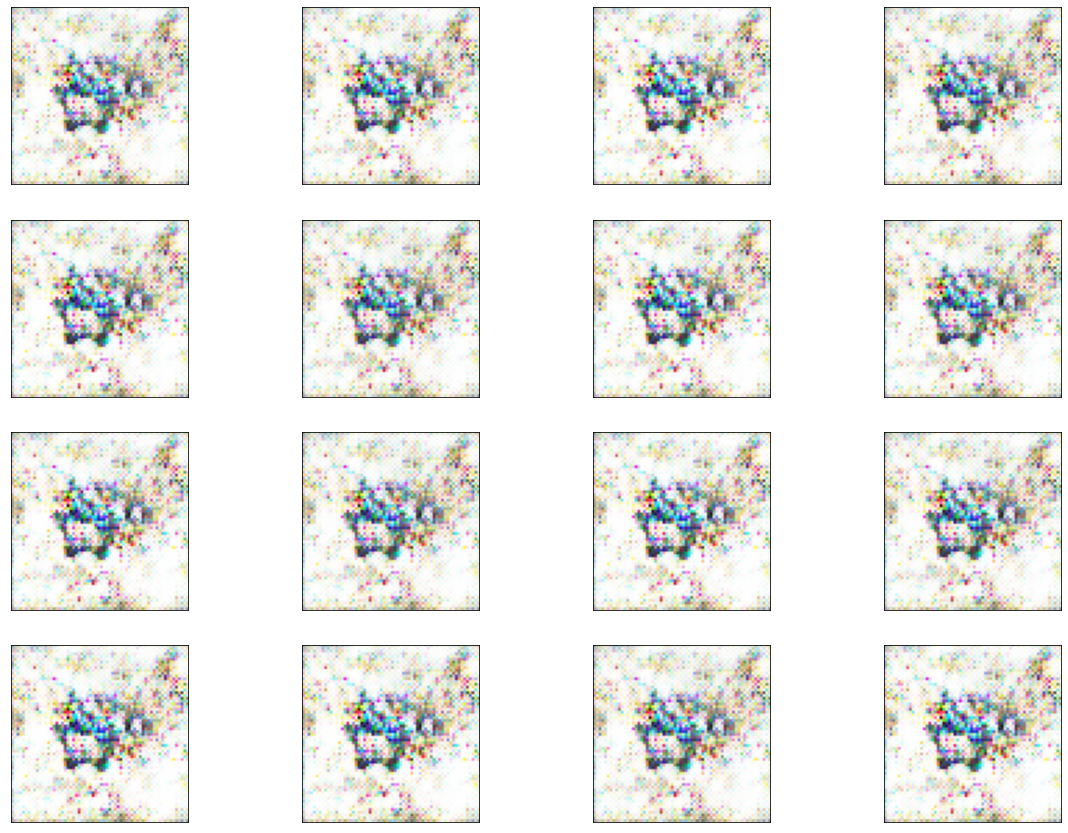

In [34]:
being_class = 1 # np.random.randint(10)
n = 1
base_noise = gan.get_random_noise(n)
n_row = 4
n_col = 4
fig, axes = plt.subplots(figsize=(20, 3 * 5) , nrows=n_row, 
                                 ncols=n_col)
for ax in axes.reshape(-1):
    noise = base_noise + (torch.randn_like(base_noise))/2
    with torch.no_grad():
        classes = torch.ones((n, ), device=var.device).long() * being_class
        gan.generator.eval()
        fakes = gan.generator.forward(noise, classes)
    fakes_grid = ut.images_grid(fakes[0], tensorboard=False)
    ax.imshow(fakes_grid)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [301]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(5.6651, device='cuda:0'), tensor(37.1417, device='cuda:0'), tensor(1.7497, device='cuda:0'), tensor(30.0315, device='cuda:0'), tensor(0.9447, device='cuda:0'), tensor(10.2452, device='cuda:0'), tensor(0.7397, device='cuda:0'), tensor(5.7435, device='cuda:0'), tensor(1.0466, device='cuda:0'), tensor(3.3919, device='cuda:0'), tensor(0.4834, device='cuda:0'), tensor(2.8198, device='cuda:0'), tensor(0.4163, device='cuda:0'), tensor(4.1677, device='cuda:0'), tensor(0.4484, device='cuda:0'), tensor(1.1201, device='cuda:0'), tensor(0.2270, device='cuda:0'), tensor(1.3180, device='cuda:0'), tensor(0.2039, device='cuda:0'), tensor(3.9053, device='cuda:0'), tensor(0.7421, device='cuda:0'), tensor(0.1336, device='cuda:0'), tensor(0.7735, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(4.6653, device='cuda:0'), tensor(0.7022, device='cuda:0'), tensor(0.1534, device='cuda:0'), tensor(0.6080, device='cuda:0'), tensor(0.2281, device='cuda:0'), tensor(1.1207, device='cuda:0'), tensor

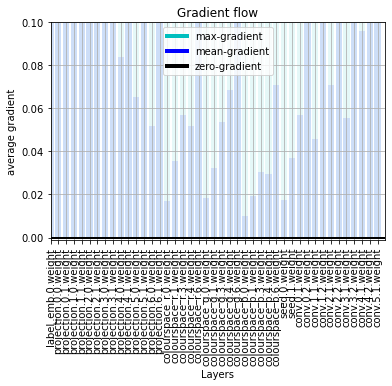

In [302]:
plot_grad_flow(gan.generator.named_parameters())

In [19]:
2e-4

0.0002